# Deep learning for muon energy reconstruction in a high-granularity calorimeter

Given the regularity of the detector configuration, processing of the raw data is also possible using 3D convolutional neural networks. This allows to exploit the granular information of the deposited energy pattern to learn high-level representations of the detector readout, which we could also combine with high-level information produced by physics-inspired statistical summaries.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import h5py
import json
import matplotlib.pyplot as plt
import sparse
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn, Tensor
import numpy as np
from typing import *
from pathlib import Path
import math
from fastprogress import master_bar, progress_bar

In [2]:
from metric import compute_improvement

In [3]:
PATH = Path("/home/centos/mount_point/data/cmu_challenge/")

In [4]:
PATH = Path("/home/centos/data/cmu_challenge/")

## Neural Network with low level features

### Data loader

In [5]:
class MuonData(Dataset):
    def __init__(self, file_name):
        self.file_name = file_name
        self.open_file()
        
    def __len__(self) -> int:
        return self.len
    
    def __del__(self) -> None:
        if hasattr(self, 'hits'): del self.hits
        if hasattr(self, 'file'): self.file.close()
            
    def open_file(self) -> None:
        self.file = h5py.File(self.file_name, "r")
        self.shape = json.loads(self.file['meta_data/matrix_feats'][()])['shape']
        all_hits = self.file['fold_0/matrix_inputs']
        coords = all_hits[1:].astype(int)
        self.hits = sparse.COO(coords=coords, data=all_hits[0], shape=[coords[0][-1]+1]+self.shape)
        self.hl_inputs = self.file['fold_0/inputs'][()]
        self.targets = self.file['fold_0/targets'][()]
        self.len = len(self.file['fold_0/targets'])
    
    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, float]: 
        if not hasattr(self, 'file'): self.open_file()
        return self.hl_inputs[idx], self.hits[idx].todense(), self.targets[idx]

### Model

As a starting point we provide a 3D CNN model. The convolutional part of the model consists of blocks. The first block downsamples the data and increases the number of  channels to eight in the first down-sample, and then increase the number of channels at each downsample by a factor of 1.5. Adding further convolutional blocks makes the network deeper. Finally the output of the convolutional blocks is fed into fully connected layers.

In [6]:
class cnn3d(nn.Module):
    def __init__(self, n_layers_per_res:int=1, channel_coef:float=1.5, device:Optional[torch.device]=None):
        super().__init__()
        if device is None: device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.device = device
        self.conv_layers = self._build_conv_layers(n_layers_per_res, channel_coef).to(self.device)
        self.n_conv_out = self._compute_conv_out()
        self.fc_layers = self._build_fc_layers().to(self.device)

    def flatten_x(self, x:Tensor) -> Tensor:
        return x.view(x.size(0),-1)  # flatten tensor to (N, M), could be replaced by a pooling layer

    def _compute_conv_out(self) -> int:
        with torch.no_grad():
            self.conv_layers.eval()
            x = torch.zeros((1,1,50,32,32), device=self.device)
            x = self.conv_layers(x)
            x = self.flatten_x(x)
        self.conv_layers.train()
        return x.shape[1]  # number of features per muon

    def _build_conv_layers(self, n_layers_per_res:int, channel_coef:float) -> nn.Sequential:
        layers = []
        n_in = 1
        kernel_sz = 3

        for i in range(4):
            for j in range(n_layers_per_res):
                if j == 0:
                    # Downsample
                    stride = 2
                    if i == 0:
                        n_out = 8  #  large upscale on first downsample
                    else:
                        n_out = int(n_in*channel_coef)
                else:
                    stride = 1
                    n_out = n_in
                layers.append(self._get_conv_layer(n_in=n_in, n_out=n_out, kernel_sz=kernel_sz, stride=stride))
                n_in = n_out
        return nn.Sequential(*layers)
    
    def _get_conv_layer(self, n_in:int, n_out:int, kernel_sz:Union[int,Tuple[int,int,int]],
                        stride:int=1, padding:Union[str,int,Tuple[int,int,int]]='auto') -> nn.Sequential:
        layers = []
        
        if padding == 'auto': padding = kernel_sz//2 if isinstance(kernel_sz, int) else [i//2 for i in kernel_sz]
        layers.append(nn.Conv3d(in_channels=n_in, out_channels=n_out, kernel_size=kernel_sz,
                                padding=padding, stride=stride, bias=False))
        nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu', a=0)
        layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def _get_fc_layer(self, n_in:int, n_out:int, act:bool=True) -> nn.Sequential:
        layers = []
        layers.append(nn.Linear(n_in, n_out))
        nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu', a=0)
        nn.init.zeros_(layers[-1].bias)
        if act: layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def _build_fc_layers(self) -> nn.Sequential:
        layers = []
        n_in = self.n_conv_out
        for i in range(2):
            n_out = np.max((1,n_in//2))
            layers.append(self._get_fc_layer(n_in, n_out))
            n_in = n_out
        layers.append(self._get_fc_layer(n_in=n_in, n_out=1, act=False))  # Final layer single output, linear activation
        return nn.Sequential(*layers)

    def forward(self, x:Tensor) -> Tensor:
        x = self.conv_layers(x)
        x = self.flatten_x(x)
        x = self.fc_layers(x)
        return x

In [7]:
net = cnn3d()

In [8]:
net

cnn3d(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(8, 12, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv3d(12, 18, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv3d(18, 27, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
  )
  (fc_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=432, out_features=216, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=216, out_features=108, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=108, out_features=1, bias=True)
    )
  )
)

## Training loop

As a starting point we suggest to use MSE as loss function, however more advanced loss functions tailored to the physics problem can be tried.

In [9]:
training_data = MuonData(PATH/'muon_calo_train.hdf5')

In [10]:
val_data = MuonData(PATH/'muon_calo_val.hdf5')

In [11]:
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=1000, shuffle=False, num_workers=4)

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, bar):
    model.train()
    train_loss = 0
    for batch, (hl_feats, hits, labels) in enumerate(progress_bar(dataloader, parent=bar)):
        
        labels = labels.unsqueeze(1)
        hits, labels = hits.to(model.device), labels.to(model.device)
        
        # Compute prediction and loss
        pred = model(hits)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        l = loss.data.item()
        train_loss += l
        if batch % 100 == 0:
            bar.child.comment = f"loss: {l:.3E}"
    
    train_loss /= len(dataloader)
    return train_loss

In [13]:
def test_loop(dataloader, model, loss_fn, bar):
    num_batches = len(dataloader)
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for hl_feats, hits, labels in progress_bar(dataloader, parent=bar):
            labels = labels.unsqueeze(1)
            hits, labels = hits.to(model.device), labels.to(model.device)
            pred = model(hits)
            test_loss += loss_fn(pred,labels).data.item()

    test_loss /= num_batches
    return test_loss

In [14]:
def save_best_model(net:nn.Module, save_path:Path) -> None:
    save_path.mkdir(parents=True, exist_ok=True)
    torch.save({'model':net.state_dict()}, str(save_path/'best.pt'))

In [15]:
def load_best_model(net:nn.Module, load_path:Path) -> None:
    state = torch.load(str(load_path/'best.pt'), map_location=net.device.type)
    net.load_state_dict(state['model'])

In [16]:
def update_plot(bar, epoch, train_loss, valid_loss, start=1):
    if epoch >= start:
        bar.update_graph([[range(start, epoch+1),np.log10(train_loss[1:])], [range(start, epoch+1),np.log10(valid_loss[1:])]])
        bar.ax.set_xlabel('Epoch')
        bar.ax.set_ylabel('Log Loss')
        bar.out2.update(bar.ax.figure)

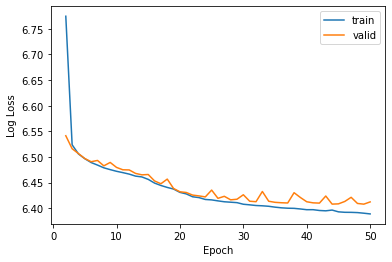

Done!
CPU times: user 11min 58s, sys: 11min 13s, total: 23min 11s
Wall time: 22min 54s


In [17]:
%%time

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

epochs = 50
lowest_loss = math.inf
save_path = Path('weights')
train_loss, valid_loss = [], []

bar = master_bar(range(1,epochs+1))

for epoch in bar:
    train_loss.append(train_loop(train_dataloader, net, loss_fn, optimizer, bar=bar))
    valid_loss.append(test_loop(val_dataloader, net, loss_fn, bar=bar))
    if valid_loss[-1] < lowest_loss:
        save_best_model(net, save_path)
        lowest_loss = valid_loss[-1]
        bar.first_bar.comment = f'Best loss: {lowest_loss:.3E}'
    update_plot(bar, epoch, train_loss, valid_loss, start=2)
print("Done!")

In [18]:
load_best_model(net, save_path)

## Validation

In [19]:
def compute_predictions(dataloader, model):
        
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        for hl_feats, hits, labels in dataloader:
            hits = hits.to(net.device)
            predictions.append(model(hits).cpu().detach().numpy())
            targets.append(labels)
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    return predictions, targets

In [20]:
preds, targs = compute_predictions(val_dataloader, net)

In [21]:
df = pd.DataFrame({'pred': preds.squeeze(), 'target': targs})

In [22]:
df.head()

,pred,target
0,4915.413574,5709.742676
1,4847.445801,5540.189453
2,5938.611816,2945.265869
3,4713.255859,5475.326660
4,5427.355957,7548.465332


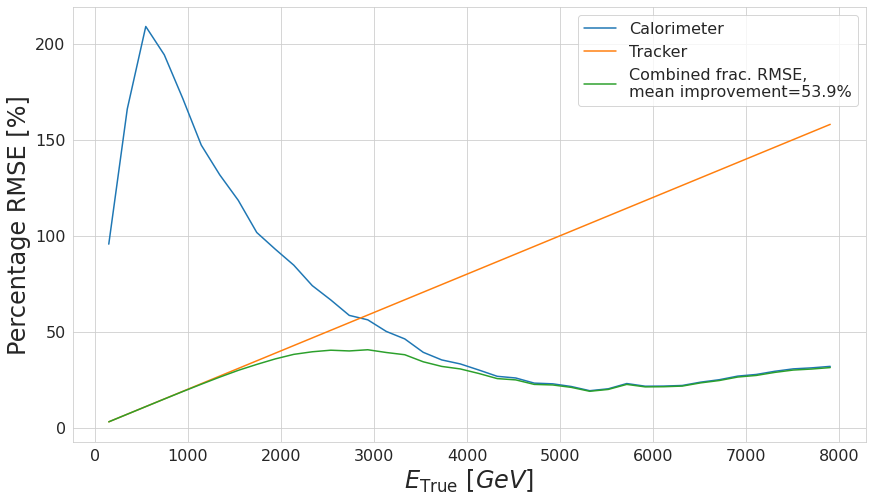

0.5386287400018236

In [23]:
compute_improvement(df)

## Submission

In [24]:
del training_data, train_dataloader, val_data, val_dataloader

In [25]:
sub_data = MuonData(PATH/'muon_calo_test.hdf5')

In [26]:
sub_dataloader = DataLoader(sub_data, batch_size=1000, shuffle=False, num_workers=4)

In [27]:
preds,_ = compute_predictions(sub_dataloader, net)

In [28]:
def create_submission(preds, name="submission"):
    df = pd.DataFrame(preds, columns=["prediction"])
    df.to_csv(name + ".csv")

In [29]:
create_submission(preds)

In [30]:
del sub_data, sub_dataloader